In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=553315 sha256=4eeec29dd95242112b49bcd4c794818c5d9e088d48c0db8aaa2efb5643dd0164
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import io
from tensorflow.keras.models import Model
from PIL import Image
from annoy import AnnoyIndex
from sklearn.metrics.pairwise import cosine_similarity

## Feature Extraction and Indexing Using a Fine-Tuned ResNet Model

In [61]:
def load_and_extract_features(model_path, image_dir):
    """
    Loads a pre-trained model and extracts feature embeddings from images.
    """

    # Loading the pre-trained model
    try:
        model_path = "/content/best_resnet_finetuned.keras"
        model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully.")
        model.summary()
    except Exception as load_error:
        print(f"Error loading model: {load_error}")
        return [], []

    # Creating a feature extractor
    try:
        base_model = model.layers[0]
        feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
        print("Feature extractor created successfully.")
    except Exception as extractor_error:
        print(f"Error creating feature extractor: {extractor_error}")
        return [], []

    image_paths, features = [], []

    # Processing images from the directory
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)

        try:
            # Loading and preprocessing the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

            # Extracting and flattening features
            try:
                feature_vec = feature_extractor.predict(img_array).flatten()
                image_paths.append(img_path)
                features.append(feature_vec)
            except Exception as predict_error:
                pass  # Skipping images with prediction errors

        except Exception as img_error:
            pass  # Skipping images with loading errors

    print(f"\nTotal images processed: {len(features)}")
    return image_paths, features


In [62]:
# Setting model and image directory paths
model_path = "/content/best_resnet_finetuned.keras"
image_dir = "/content/drive/MyDrive/nga_dataset/images"

# Extracting features from images
image_paths, features = load_and_extract_features(model_path, image_dir)

# Proceeding only if features are extracted
if features:
    # Determining feature vector dimension
    feature_dim = len(features[0])

    # Initializing Annoy Index with angular distance metric
    annoy_index = AnnoyIndex(feature_dim, 'angular')

    # Adding extracted features to the Annoy Index
    for i, feature in enumerate(features):
        annoy_index.add_item(i, feature)

    # Building and saving the Annoy Index
    annoy_index.build(50)
    annoy_index.save("/content/drive/MyDrive/nga_dataset/painting_annoy_index_resnet.ann")

    # Saving extracted feature vectors
    np.save("/content/drive/MyDrive/nga_dataset/painting_features_resnet.npy", features)

    print("Feature Extraction & Indexing Complete!")
else:
    print("No features extracted. Cannot create index.")


Model loaded successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,073,370 (244.42 MB)

 Trainable params: 19,979,528 (76.22 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

 Optimizer params: 39,959,058 (152.43 MB)

Feature extractor created successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

### Finding Similar Paintings Using Annoy and Cosine Similarity

In [63]:
def get_cosine_similarity(query_features, dataset_features):
    """Compute cosine similarity between query features and dataset features"""
    return cosine_similarity([query_features], dataset_features)

def extract_query_features(model_path, query_img_path):
    """
    Extract features for a query image using the saved ResNet model
    """
    try:
        # Loading the trained model
        model = tf.keras.models.load_model(model_path, compile=False)

        # Creating feature extractor from the base model
        base_model = model.layers[0]
        feature_extractor = Model(
            inputs=base_model.input,
            outputs=base_model.output  # Using the base model output as features
        )

        # Loading and preprocessing the query image
        img = tf.keras.preprocessing.image.load_img(query_img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Applying ResNet50 preprocessing
        img_array = tf.keras.applications.resnet.preprocess_input(img_array)

        # Extracting features from the query image
        features = feature_extractor.predict(img_array)

        return features.flatten()

    except Exception as e:
        print(f"Feature extraction error: {e}")
        return None

In [65]:
def find_similar_paintings(query_img_path, top_k=5):
    """
    Find similar paintings using the Annoy index
    """
    # Define paths for saved model, features, and index
    model_path = "/content/best_resnet_finetuned.keras"
    features_path = "/content/drive/MyDrive/nga_dataset/painting_features_resnet.npy"
    index_path = "/content/drive/MyDrive/nga_dataset/painting_annoy_index_resnet.ann"
    image_dir = "/content/drive/MyDrive/nga_dataset/images"

    # Extract features from the query image
    query_features = extract_query_features(model_path, query_img_path)

    if query_features is None:
        print("Could not extract features from the query image")
        return []

    # Load saved feature vectors
    features = np.load(features_path)

    # Get all image paths in the dataset
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]

    # Determine feature dimension
    feature_dim = len(query_features)

    # Load the Annoy index
    annoy_index = AnnoyIndex(feature_dim, 'angular')
    annoy_index.load(index_path)

    # Retrieve the top-K most similar images
    similar_indices = annoy_index.get_nns_by_vector(query_features, top_k + 1)  # Retrieve one extra for redundancy

    # Map indices to image paths
    similar_images = [image_paths[i] for i in similar_indices]

    # Ensure the query image is not in the results
    if query_img_path in similar_images:
        similar_images.remove(query_img_path)

    return similar_images[:top_k]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Similar Paintings Found: ['/content/drive/MyDrive/nga_dataset/images/34148.jpg', '/content/drive/MyDrive/nga_dataset/images/42917.jpg', '/content/drive/MyDrive/nga_dataset/images/32695.jpg', '/content/drive/MyDrive/nga_dataset/images/1121.jpg', '/content/drive/MyDrive/nga_dataset/images/43597.jpg']


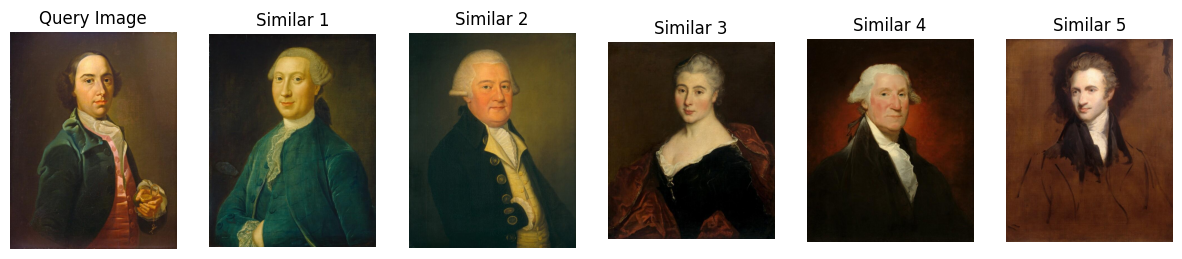

In [66]:
# Query image path
query_image = "/content/drive/MyDrive/nga_dataset/images/1095.jpg"

# Find similar paintings
similar_paintings = find_similar_paintings(query_image)
print("Similar Paintings Found:", similar_paintings)

# Display query and similar images
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.title("Query Image")
plt.imshow(mpimg.imread(query_image))
plt.axis('off')

for i, similar_img in enumerate(similar_paintings, 1):
    plt.subplot(1, 6, i + 1)
    plt.title(f"Similar {i}")
    plt.imshow(mpimg.imread(similar_img))
    plt.axis('off')

plt.show()

### Fixing and Verifying Image Paths in Dataset

In [22]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/nga_dataset/processed/portrait_dataset.csv")

# Fix image path format
df["image_path"] = df["image_path"].str.replace("\\", "/")
df["image_path"] = df["image_path"].apply(lambda x: "/content/drive/MyDrive/" + x if not x.startswith("/content") else x)

# Save the corrected dataset
df.to_csv("/content/drive/MyDrive/nga_dataset/processed/portrait_dataset_fixed.csv", index=False)

print("File paths corrected!")

# Verify changes
df = pd.read_csv("/content/drive/MyDrive/nga_dataset/processed/portrait_dataset_fixed.csv")
print(df["image_path"].head())


File paths corrected!
0    /content/drive/MyDrive/nga_dataset/images/19.jpg
1    /content/drive/MyDrive/nga_dataset/images/25.jpg
2    /content/drive/MyDrive/nga_dataset/images/38.jpg
3    /content/drive/MyDrive/nga_dataset/images/49.jpg
4    /content/drive/MyDrive/nga_dataset/images/59.jpg
Name: image_path, dtype: object


In [10]:
# Verifying changes
df = pd.read_csv("/content/drive/MyDrive/nga_dataset/processed/portrait_dataset_fixed.csv")
print(df["image_path"].head())

0    /content/drive/MyDrive/nga_dataset/images/19.jpg
1    /content/drive/MyDrive/nga_dataset/images/25.jpg
2    /content/drive/MyDrive/nga_dataset/images/38.jpg
3    /content/drive/MyDrive/nga_dataset/images/49.jpg
4    /content/drive/MyDrive/nga_dataset/images/59.jpg
Name: image_path, dtype: object


### Evaluating Similarity Search with Quality Metric and Visualization

In [67]:
def calculate_quality_metric(k, n, k_approximate):
    """
    Compute the quality metric based on the given formula.
    """
    return k / (n * k_approximate)

def perform_similarity_search(query_feature, annoy_index, image_paths, num_results=10):
    """
    Retrieve similar images using the ANNOY index.
    """
    similar_indices = annoy_index.get_nns_by_vector(query_feature, num_results, include_distances=True)

    # Extract image paths and distances
    similar_image_paths = [image_paths[idx] for idx in similar_indices[0]]
    distances = similar_indices[1]

    return similar_image_paths, distances


In [68]:
def visualize_similar_images(query_image_path, similar_image_paths, distances):
    """
    Display the query image along with its similar images.
    """
    plt.figure(figsize=(15, 3))

    # Show query image
    plt.subplot(1, len(similar_image_paths) + 1, 1)
    plt.imshow(Image.open(query_image_path))
    plt.title('Query Image')
    plt.axis('off')

    # Show similar images
    for i, (img_path, dist) in enumerate(zip(similar_image_paths, distances), 1):
        plt.subplot(1, len(similar_image_paths) + 1, i + 1)
        plt.imshow(Image.open(img_path))
        plt.title(f'Dist: {dist:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Quality Metric: 0.0052


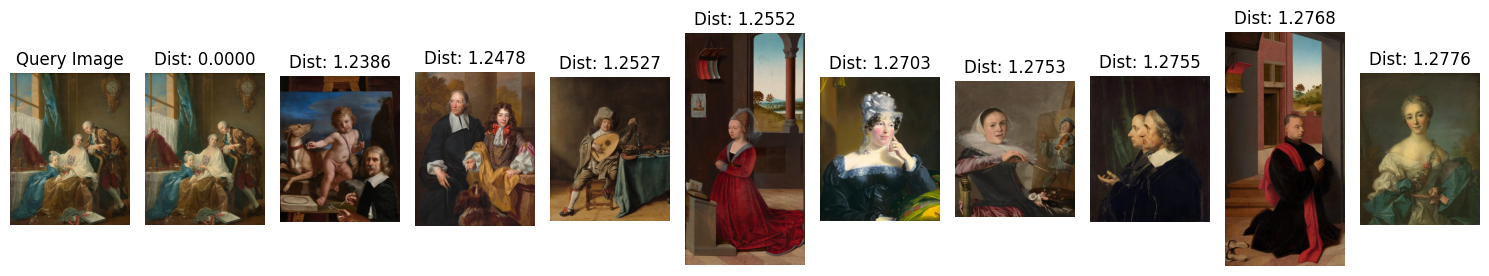

In [69]:
# Load pre-computed features and paths
features = np.load("/content/drive/MyDrive/nga_dataset/painting_features_resnet.npy")
image_dir = "/content/drive/MyDrive/nga_dataset/images"
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]

# Load ANNOY index
feature_dim = features.shape[1]
annoy_index = AnnoyIndex(feature_dim, 'angular')
annoy_index.load("/content/drive/MyDrive/nga_dataset/painting_annoy_index_resnet.ann")

# Example query (random image)
query_index = np.random.randint(0, len(features))
query_feature = features[query_index]
query_image_path = image_paths[query_index]

# Parameters for quality metric calculation
k = 20  # Exact nearest neighbors
n = len(features)  # Total images
k_approximate = 20  # Approximate nearest neighbors

# Calculate quality metric
quality = calculate_quality_metric(k, n, k_approximate)
print(f"Quality Metric: {quality:.4f}")

# Perform similarity search
similar_image_paths, distances = perform_similarity_search(
    query_feature, annoy_index, image_paths, num_results=10
)

# Visualize results
visualize_similar_images(query_image_path, similar_image_paths, distances)


### Comprehensive Evaluation of Image Similarity Retrieval

In [ ]:
def extract_features(model_path, image_paths):
    """Extract features from images using a pre-trained model."""
    try:
        model = tf.keras.models.load_model(model_path, compile=False)  # Load ResNet model
        base_model = model.layers[0]
        feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

        features, valid_paths = [], []
        for img_path in image_paths:
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = tf.keras.applications.resnet.preprocess_input(img_array)  # Use ResNet preprocessing

                feature = feature_extractor.predict(img_array, verbose=0)
                features.append(feature.flatten())
                valid_paths.append(img_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

        return features, valid_paths

    except Exception as e:
        print(f"Feature extraction error: {e}")
        return [], []

In [71]:
def feature_similarity_metrics(query_image, retrieved_images, model_path):
    """Calculate feature-based similarity metrics."""
    all_images = [query_image] + retrieved_images
    features, valid_paths = extract_features(model_path, all_images)

    if not features or len(features) < 2:
        print("Feature extraction failed")
        return None, None, None

    query_feature = features[0]
    retrieved_features = features[1:]

    # Compute cosine similarities
    similarities = [
        cosine_similarity(query_feature.reshape(1, -1), feat.reshape(1, -1))[0][0]
        for feat in retrieved_features
    ]

    # Compute mean similarity
    mean_similarity = np.mean(similarities) if similarities else 0

    # Compute precision@k based on similarity threshold
    similarity_threshold = 0.8
    relevant_count = sum(1 for sim in similarities if sim >= similarity_threshold)
    feature_precision = relevant_count / len(similarities) if similarities else 0

    return similarities, mean_similarity, feature_precision

def evaluate_visual_similarity(df, sample_size=5, k=5, model_path="/content/best_resnet_finetuned.keras"):
    """Evaluate visual similarity using feature-based metrics."""
    df = df[df['image_path'].apply(os.path.exists)]  # Filter valid image paths
    sample_queries = random.sample(df['image_path'].tolist(), min(sample_size, len(df)))

    visual_results, mean_similarities, feature_precisions = [], [], []

    for query_img in sample_queries:
        try:
            retrieved_images = find_similar_paintings(query_img, top_k=k)

            similarities, mean_sim, feature_prec = feature_similarity_metrics(
                query_img, retrieved_images, model_path
            )

            if similarities:
                mean_similarities.append(mean_sim)
                feature_precisions.append(feature_prec)

                visual_results.append({
                    'query_image': query_img,
                    'retrieved_images': retrieved_images,
                    'similarities': similarities,
                    'mean_similarity': mean_sim,
                    'feature_precision': feature_prec
                })

                print(f"Query: {query_img}")
                print(f"  Mean Similarity: {mean_sim:.4f}")
                print(f"  Feature Precision: {feature_prec:.4f}")

        except Exception as e:
            print(f"Error evaluating {query_img}: {e}")

    # Compute overall metrics
    overall_mean_similarity = np.mean(mean_similarities) if mean_similarities else 0
    overall_feature_precision = np.mean(feature_precisions) if feature_precisions else 0

    print("\n🔹 Visual Similarity Evaluation Summary:")
    print(f"Total Queries: {len(visual_results)}")
    print(f"Mean Similarity: {overall_mean_similarity:.4f}")
    print(f"Feature Precision: {overall_feature_precision:.4f}")

    return visual_results, overall_mean_similarity, overall_feature_precision

In [72]:
def combined_evaluation_metrics(df, sample_size=5, k=5, similarity_threshold=0.8, model_path="/content/best_resnet_finetuned.keras"):
    """Comprehensive evaluation combining title-based and visual feature-based metrics."""
    df = df[df['image_path'].apply(os.path.exists)]  # Filter valid image paths
    sample_queries = random.sample(df[['image_path', 'title']].values.tolist(), min(sample_size, len(df)))

    combined_results = []

    for query_img_path, query_title in sample_queries:
        try:
            retrieved_images = find_similar_paintings(query_img_path, top_k=k)

            # Title-based metrics
            precision = precision_at_k(retrieved_images, query_title, df, k, similarity_threshold)
            ap = average_precision(retrieved_images, query_title, df, similarity_threshold)

            # Visual similarity metrics
            similarities, mean_sim, feature_prec = feature_similarity_metrics(
                query_img_path, retrieved_images, model_path
            )

            # Combined metric (weighted average)
            if similarities:
                title_weight, visual_weight = 0.4, 0.6
                combined_score = (title_weight * precision) + (visual_weight * mean_sim)

                combined_results.append({
                    'query_image': query_img_path,
                    'query_title': query_title,
                    'retrieved_images': retrieved_images,
                    'title_precision': precision,
                    'average_precision': ap,
                    'visual_similarity': mean_sim,
                    'feature_precision': feature_prec,
                    'combined_score': combined_score
                })

                print(f"\nQuery: {query_title}")
                print(f"  Title Precision@{k}: {precision:.4f}")
                print(f"  Average Precision: {ap:.4f}")
                print(f"  Visual Similarity: {mean_sim:.4f}")
                print(f"  Combined Score: {combined_score:.4f}")

        except Exception as e:
            print(f"Error evaluating {query_img_path}: {e}")

    # Overall metrics
    if combined_results:
        mean_title_precision = np.mean([r['title_precision'] for r in combined_results])
        mean_ap = np.mean([r['average_precision'] for r in combined_results])
        mean_visual_similarity = np.mean([r['visual_similarity'] for r in combined_results])
        mean_combined_score = np.mean([r['combined_score'] for r in combined_results])

        print("\n🔹 Combined Evaluation Summary:")
        print(f"Total Queries: {len(combined_results)}")
        print(f"Mean Title Precision@{k}: {mean_title_precision:.4f}")
        print(f"Mean Average Precision: {mean_ap:.4f}")
        print(f"Mean Visual Similarity: {mean_visual_similarity:.4f}")
        print(f"Mean Combined Score: {mean_combined_score:.4f}")

    return combined_results

In [73]:
def visualize_retrieval_results(query_img_path, retrieved_images, df=None, similarities=None):
    """Visualize query image and retrieved results with similarity scores."""
    n_retrieved = len(retrieved_images)
    fig, axs = plt.subplots(1, n_retrieved + 1, figsize=(15, 3))

    axs[0].imshow(Image.open(query_img_path))
    axs[0].set_title("Query Image")
    axs[0].axis('off')

    for i, img_path in enumerate(retrieved_images):
        try:
            axs[i + 1].imshow(Image.open(img_path))
            title = df[df['image_path'] == img_path]['title'].values[0] if df is not None else ""
            title = (title[:20] + "...") if len(title) > 20 else title
            sim_score = f"Sim: {similarities[i]:.2f}" if similarities and i < len(similarities) else ""

            axs[i + 1].set_title(f"{i+1}. {title}\n{sim_score}")
            axs[i + 1].axis('off')
        except Exception as e:
            print(f"Error displaying image {img_path}: {e}")

    plt.tight_layout()
    return fig


========== RUNNING COMPREHENSIVE EVALUATION ==========


Evaluating Title-Based Metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Match Found:
  Query Title: Portrait of an Elderly Lady
  Retrieved Title: Portrait of a Lady
  Similarity: 0.80
Match Found:
  Query Title: Portrait of an Elderly Lady
  Retrieved Title: Portrait of an Old Lady
  Similarity: 0.88
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Match Found:
  Query Title: Portrait of a Gentleman
  Retrieved Title: Portrait of a Gentleman
  Similarity: 1.00
Match Found:
  Query Title: Portrait of a Gentleman
  Retrieved Title: Portrait of a Man
  Similarity: 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🔹 Evaluation Summary:
Total Queries: 5
Precision@5: 0.16

Evaluating Visual Feature Metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Query: /content/drive/MyDrive/nga_dataset/images/34124.jpg
  Mean Similarity: 0.5899
  Feature Precision: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


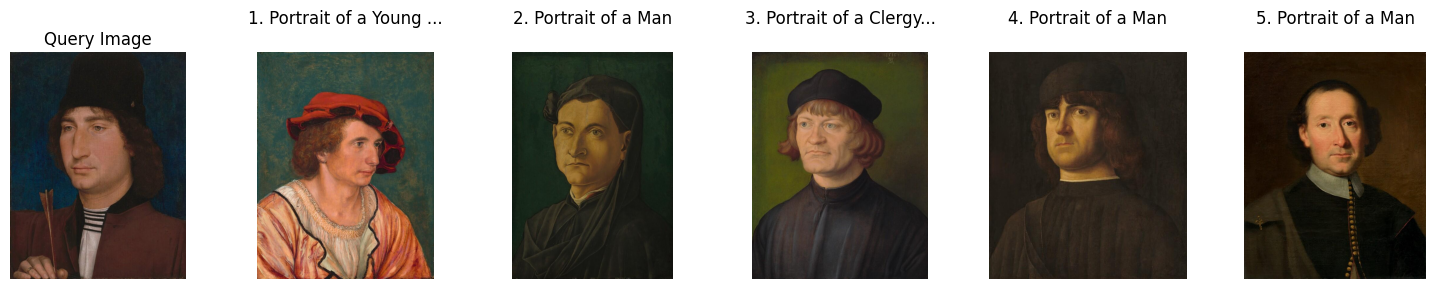

In [75]:
def run_comprehensive_evaluation(df, sample_size=5, k=5):
    """Run a comprehensive evaluation using both title and visual feature metrics."""
    print("\n========== RUNNING COMPREHENSIVE EVALUATION ==========\n")

    print("\nEvaluating Title-Based Metrics")
    precision_scores, detailed_results = evaluate_similarity_search(df, sample_size, k)

    print("\nEvaluating Visual Feature Metrics")
    visual_results, overall_mean_similarity, overall_feature_precision = evaluate_visual_similarity(df, sample_size, k)

    print("\nEvaluating Combined Metrics")
    combined_results = combined_evaluation_metrics(df, sample_size, k)

    if combined_results:
        example = combined_results[0]
        query_img = example['query_image']
        retrieved = example['retrieved_images']
        similarities = next((vr['similarities'] for vr in visual_results if vr['query_image'] == query_img), None)

        print("\nVisualizing Example Retrieval Results")
        fig = visualize_retrieval_results(query_img, retrieved, df, similarities)
        plt.show()

    return {
        'title_metrics': detailed_results,
        'visual_metrics': visual_results,
        'combined_metrics': combined_results
    }

# Example usage:
results = run_comprehensive_evaluation(df, sample_size=5, k=5)

## Feature Extraction and Indexing Using a Fine-Tuned EfficientNet Model

In [35]:
def load_and_extract_features(model_path, image_dir):
    """
    Loads a pre-trained model and extracts feature embeddings from images.
    """

    # Loading the pre-trained model
    try:
        model_path = "/content/efficientnet_finetuned.keras"
        model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully.")
        model.summary()
    except Exception as load_error:
        print(f"Error loading model: {load_error}")
        return [], []

    # Creating a feature extractor
    try:
        base_model = model.layers[0]
        feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
        print("Feature extractor created successfully.")
    except Exception as extractor_error:
        print(f"Error creating feature extractor: {extractor_error}")
        return [], []

    image_paths, features = [], []

    # Processing images from the directory
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)

        try:
            # Loading and preprocessing the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

            # Extracting and flattening features
            try:
                feature_vec = feature_extractor.predict(img_array).flatten()
                image_paths.append(img_path)
                features.append(feature_vec)
            except Exception as predict_error:
                pass  # Skipping images with prediction errors

        except Exception as img_error:
            pass  # Skipping images with loading errors

    print(f"\nTotal images processed: {len(features)}")
    return image_paths, features


In [36]:
# Setting model and image directory paths
model_path = "/content/efficientnet_finetuned.keras"
image_dir = "/content/drive/MyDrive/nga_dataset/images"

# Extracting features from images
image_paths, features = load_and_extract_features(model_path, image_dir)

# Proceeding only if features are extracted
if features:
    # Determining feature vector dimension
    feature_dim = len(features[0])

    # Initializing Annoy Index with angular distance metric
    annoy_index = AnnoyIndex(feature_dim, 'angular')

    # Adding extracted features to the Annoy Index
    for i, feature in enumerate(features):
        annoy_index.add_item(i, feature)

    # Building and saving the Annoy Index
    annoy_index.build(50)
    annoy_index.save("/content/drive/MyDrive/nga_dataset/painting_annoy_index.ann")

    # Saving extracted feature vectors
    np.save("/content/drive/MyDrive/nga_dataset/painting_features.npy", features)

    print("Feature Extraction & Indexing Complete!")
else:
    print("No features extracted. Cannot create index.")


Model loaded successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,129,141 (38.64 MB)

 Trainable params: 2,874,788 (10.97 MB)

 Non-trainable params: 1,504,775 (5.74 MB)

 Optimizer params: 5,749,578 (21.93 MB)

Feature extractor created successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/

### Finding Similar Paintings Using Annoy and Cosine Similarity

In [19]:
def get_cosine_similarity(query_features, dataset_features):
    """Compute cosine similarity between query features and dataset features"""
    return cosine_similarity([query_features], dataset_features)

def extract_query_features(model_path, query_img_path):
    """
    Extract features for a query image using the saved model
    """
    try:
        # Loading the trained model
        model = tf.keras.models.load_model(model_path, compile=False)

        # Creating feature extractor from the base model
        base_model = model.layers[0]
        feature_extractor = Model(
            inputs=base_model.input,
            outputs=base_model.output  # Using the base model output as features
        )

        # Loading and preprocessing the query image
        img = tf.keras.preprocessing.image.load_img(query_img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Applying EfficientNetB0 preprocessing
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        # Extracting features from the query image
        features = feature_extractor.predict(img_array)

        return features.flatten()

    except Exception as e:
        print(f"Feature extraction error: {e}")
        return None


In [20]:
def find_similar_paintings(query_img_path, top_k=5):
    """
    Find similar paintings using the Annoy index
    """
    # Define paths for saved model, features, and index
    model_path = "/content/efficientnet_finetuned.keras"
    features_path = "/content/drive/MyDrive/nga_dataset/painting_features.npy"
    index_path = "/content/drive/MyDrive/nga_dataset/painting_annoy_index.ann"
    image_dir = "/content/drive/MyDrive/nga_dataset/images"

    # Extract features from the query image
    query_features = extract_query_features(model_path, query_img_path)

    if query_features is None:
        print("Could not extract features from the query image")
        return []

    # Load saved feature vectors
    features = np.load(features_path)

    # Get all image paths in the dataset
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]

    # Determine feature dimension
    feature_dim = len(query_features)

    # Load the Annoy index
    annoy_index = AnnoyIndex(feature_dim, 'angular')
    annoy_index.load(index_path)

    # Retrieve the top-K most similar images
    similar_indices = annoy_index.get_nns_by_vector(query_features, top_k + 1)  # Retrieve one extra for redundancy

    # Map indices to image paths
    similar_images = [image_paths[i] for i in similar_indices]

    # Ensure the query image is not in the results
    if query_img_path in similar_images:
        similar_images.remove(query_img_path)

    return similar_images[:top_k]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Similar Paintings Found: ['/content/drive/MyDrive/nga_dataset/images/195727.jpg', '/content/drive/MyDrive/nga_dataset/images/177526.jpg', '/content/drive/MyDrive/nga_dataset/images/1131.jpg', '/content/drive/MyDrive/nga_dataset/images/46500.jpg', '/content/drive/MyDrive/nga_dataset/images/1209.jpg']


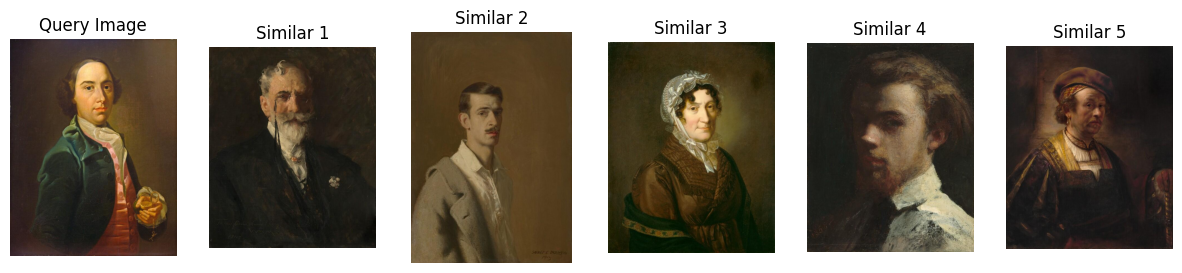

In [21]:
# Query image path
query_image = "/content/drive/MyDrive/nga_dataset/images/1095.jpg"

# Find similar paintings
similar_paintings = find_similar_paintings(query_image)
print("Similar Paintings Found:", similar_paintings)

# Display query and similar images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.title("Query Image")
plt.imshow(mpimg.imread(query_image))
plt.axis('off')

for i, similar_img in enumerate(similar_paintings, 1):
    plt.subplot(1, 6, i + 1)
    plt.title(f"Similar {i}")
    plt.imshow(mpimg.imread(similar_img))
    plt.axis('off')

plt.show()


### Evaluating Similarity Search with Quality Metric and Visualization

In [23]:
def calculate_quality_metric(k, n, k_approximate):
    """
    Compute the quality metric based on the given formula.
    """
    return k / (n * k_approximate)

def perform_similarity_search(query_feature, annoy_index, image_paths, num_results=10):
    """
    Retrieve similar images using the ANNOY index.
    """
    similar_indices = annoy_index.get_nns_by_vector(query_feature, num_results, include_distances=True)

    # Extract image paths and distances
    similar_image_paths = [image_paths[idx] for idx in similar_indices[0]]
    distances = similar_indices[1]

    return similar_image_paths, distances


In [25]:
def visualize_similar_images(query_image_path, similar_image_paths, distances):
    """
    Display the query image along with its similar images.
    """
    plt.figure(figsize=(15, 3))

    # Show query image
    plt.subplot(1, len(similar_image_paths) + 1, 1)
    plt.imshow(Image.open(query_image_path))
    plt.title('Query Image')
    plt.axis('off')

    # Show similar images
    for i, (img_path, dist) in enumerate(zip(similar_image_paths, distances), 1):
        plt.subplot(1, len(similar_image_paths) + 1, i + 1)
        plt.imshow(Image.open(img_path))
        plt.title(f'Dist: {dist:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Quality Metric: 0.0052


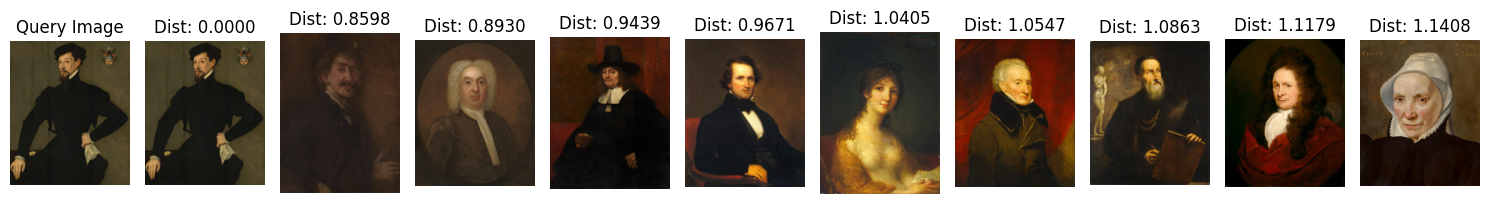

In [26]:
# Load pre-computed features and paths
features = np.load("/content/drive/MyDrive/nga_dataset/painting_features.npy")
image_dir = "/content/drive/MyDrive/nga_dataset/images"
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]

# Load ANNOY index
feature_dim = features.shape[1]
annoy_index = AnnoyIndex(feature_dim, 'angular')
annoy_index.load("/content/drive/MyDrive/nga_dataset/painting_annoy_index.ann")

# Example query (random image)
query_index = np.random.randint(0, len(features))
query_feature = features[query_index]
query_image_path = image_paths[query_index]

# Parameters for quality metric calculation
k = 20  # Exact nearest neighbors
n = len(features)  # Total images
k_approximate = 20  # Approximate nearest neighbors

# Calculate quality metric
quality = calculate_quality_metric(k, n, k_approximate)
print(f"Quality Metric: {quality:.4f}")

# Perform similarity search
similar_image_paths, distances = perform_similarity_search(
    query_feature, annoy_index, image_paths, num_results=10
)

# Visualize results
visualize_similar_images(query_image_path, similar_image_paths, distances)


### Comprehensive Evaluation of Image Similarity Retrieval

In [27]:
def extract_features(model_path, image_paths):
    """Extract features from images using a pre-trained model."""
    try:
        model = tf.keras.models.load_model(model_path, compile=False)
        base_model = model.layers[0]
        feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

        features, valid_paths = [], []
        for img_path in image_paths:
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

                feature = feature_extractor.predict(img_array, verbose=0)
                features.append(feature.flatten())
                valid_paths.append(img_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

        return features, valid_paths

    except Exception as e:
        print(f"Feature extraction error: {e}")
        return [], []


In [28]:
def feature_similarity_metrics(query_image, retrieved_images, model_path):
    """Calculate feature-based similarity metrics."""
    # Extract features for query and retrieved images
    all_images = [query_image] + retrieved_images
    features, valid_paths = extract_features(model_path, all_images)

    if not features or len(features) < 2:
        print("Feature extraction failed")
        return None, None, None

    query_feature = features[0]
    retrieved_features = features[1:]

    # Compute cosine similarities
    similarities = [
        cosine_similarity(query_feature.reshape(1, -1), feat.reshape(1, -1))[0][0]
        for feat in retrieved_features
    ]

    # Compute mean similarity
    mean_similarity = np.mean(similarities) if similarities else 0

    # Compute precision@k based on similarity threshold
    similarity_threshold = 0.8
    relevant_count = sum(1 for sim in similarities if sim >= similarity_threshold)
    feature_precision = relevant_count / len(similarities) if similarities else 0

    return similarities, mean_similarity, feature_precision


def evaluate_visual_similarity(df, sample_size=5, k=5, model_path=None):
    """Evaluate visual similarity using feature-based metrics."""
    if model_path is None:
        model_path = "/content/efficientnet_finetuned.keras"

    df = df[df['image_path'].apply(os.path.exists)]  # Filter valid image paths
    sample_queries = random.sample(df['image_path'].tolist(), min(sample_size, len(df)))

    visual_results, mean_similarities, feature_precisions = [], [], []

    for query_img in sample_queries:
        try:
            retrieved_images = find_similar_paintings(query_img, top_k=k)

            similarities, mean_sim, feature_prec = feature_similarity_metrics(
                query_img, retrieved_images, model_path
            )

            if similarities:
                mean_similarities.append(mean_sim)
                feature_precisions.append(feature_prec)

                visual_results.append({
                    'query_image': query_img,
                    'retrieved_images': retrieved_images,
                    'similarities': similarities,
                    'mean_similarity': mean_sim,
                    'feature_precision': feature_prec
                })

                print(f"Query: {query_img}")
                print(f"  Mean Similarity: {mean_sim:.4f}")
                print(f"  Feature Precision: {feature_prec:.4f}")

        except Exception as e:
            print(f"Error evaluating {query_img}: {e}")

    # Compute overall metrics
    overall_mean_similarity = np.mean(mean_similarities) if mean_similarities else 0
    overall_feature_precision = np.mean(feature_precisions) if feature_precisions else 0

    print("\n🔹 Visual Similarity Evaluation Summary:")
    print(f"Total Queries: {len(visual_results)}")
    print(f"Mean Similarity: {overall_mean_similarity:.4f}")
    print(f"Feature Precision: {overall_feature_precision:.4f}")

    return visual_results, overall_mean_similarity, overall_feature_precision


In [29]:
def combined_evaluation_metrics(df, sample_size=5, k=5, similarity_threshold=0.8, model_path=None):
    """Comprehensive evaluation combining title-based and visual feature-based metrics."""
    df = df[df['image_path'].apply(os.path.exists)]  # Filter valid image paths
    sample_queries = random.sample(df[['image_path', 'title']].values.tolist(), min(sample_size, len(df)))

    combined_results = []

    for query_img_path, query_title in sample_queries:
        try:
            retrieved_images = find_similar_paintings(query_img_path, top_k=k)

            # Title-based metrics
            precision = precision_at_k(retrieved_images, query_title, df, k, similarity_threshold)
            ap = average_precision(retrieved_images, query_title, df, similarity_threshold)

            # Visual similarity metrics
            similarities, mean_sim, feature_prec = feature_similarity_metrics(
                query_img_path, retrieved_images, model_path or "/content/efficientnet_finetuned.keras"
            )

            # Combined metric (weighted average)
            if similarities:
                title_weight, visual_weight = 0.4, 0.6
                combined_score = (title_weight * precision) + (visual_weight * mean_sim)

                combined_results.append({
                    'query_image': query_img_path,
                    'query_title': query_title,
                    'retrieved_images': retrieved_images,
                    'title_precision': precision,
                    'average_precision': ap,
                    'visual_similarity': mean_sim,
                    'feature_precision': feature_prec,
                    'combined_score': combined_score
                })

                print(f"\nQuery: {query_title}")
                print(f"  Title Precision@{k}: {precision:.4f}")
                print(f"  Average Precision: {ap:.4f}")
                print(f"  Visual Similarity: {mean_sim:.4f}")
                print(f"  Combined Score: {combined_score:.4f}")

        except Exception as e:
            print(f"Error evaluating {query_img_path}: {e}")

    # Overall metrics
    if combined_results:
        mean_title_precision = np.mean([r['title_precision'] for r in combined_results])
        mean_ap = np.mean([r['average_precision'] for r in combined_results])
        mean_visual_similarity = np.mean([r['visual_similarity'] for r in combined_results])
        mean_combined_score = np.mean([r['combined_score'] for r in combined_results])

        print("\n🔹 Combined Evaluation Summary:")
        print(f"Total Queries: {len(combined_results)}")
        print(f"Mean Title Precision@{k}: {mean_title_precision:.4f}")
        print(f"Mean Average Precision: {mean_ap:.4f}")
        print(f"Mean Visual Similarity: {mean_visual_similarity:.4f}")
        print(f"Mean Combined Score: {mean_combined_score:.4f}")

    return combined_results


In [30]:
def visualize_retrieval_results(query_img_path, retrieved_images, df=None, similarities=None):
    """Visualize query image and retrieved results with similarity scores."""
    n_retrieved = len(retrieved_images)
    fig, axs = plt.subplots(1, n_retrieved + 1, figsize=(15, 3))

    # Display query image
    axs[0].imshow(Image.open(query_img_path))
    axs[0].set_title("Query Image")
    axs[0].axis('off')

    # Display retrieved images
    for i, img_path in enumerate(retrieved_images):
        try:
            axs[i + 1].imshow(Image.open(img_path))

            # Retrieve title if available
            title = df[df['image_path'] == img_path]['title'].values[0] if df is not None else ""
            title = (title[:20] + "...") if len(title) > 20 else title

            # Retrieve similarity score if available
            sim_score = f"Sim: {similarities[i]:.2f}" if similarities and i < len(similarities) else ""

            axs[i + 1].set_title(f"{i+1}. {title}\n{sim_score}")
            axs[i + 1].axis('off')
        except Exception as e:
            print(f"Error displaying image {img_path}: {e}")

    plt.tight_layout()
    return fig



========== RUNNING COMPREHENSIVE EVALUATION ==========


Evaluating Title-Based Metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Match Found:
  Query Title: Portrait of a Young Man
  Retrieved Title: Portrait of a Young Man
  Similarity: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🔹 Evaluation Summary:
Total Queries: 5
Precision@5: 0.04

Evaluating Visual Feature Metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Query: /content/drive/MyDrive/nga_dataset/images/98594.jpg
  Mean Similarity: 0.2795
  Feature Precision: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Query: /content/drive/MyDrive/nga_dataset/images/22.jpg
  Mean Similarity: 0.3868
  Feature Precision: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Query: /content/drive/MyDrive/nga_dataset/images/323.jpg
  Mean Similarity: 0.4946
  Feature Precision: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Query: /content/drive/MyDrive/nga_dataset/imag

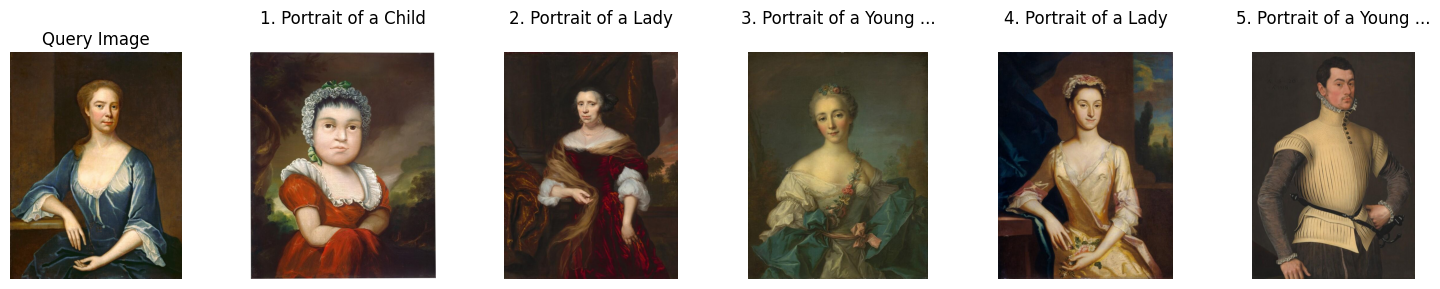

In [31]:
def run_comprehensive_evaluation(df, sample_size=5, k=5, model_path=None):
    """
    Run a comprehensive evaluation using both title and visual feature metrics.
    """
    print("\n========== RUNNING COMPREHENSIVE EVALUATION ==========\n")

    # Step 1: Evaluate using title-based metrics
    print("\nEvaluating Title-Based Metrics")
    precision_scores, detailed_results = evaluate_similarity_search(df, sample_size, k)

    # Step 2: Evaluate using visual feature metrics
    print("\nEvaluating Visual Feature Metrics")
    visual_results, overall_mean_similarity, overall_feature_precision = evaluate_visual_similarity(
        df, sample_size, k, model_path
    )

    # Step 3: Evaluate using combined metrics
    print("\nEvaluating Combined Metrics")
    combined_results = combined_evaluation_metrics(df, sample_size, k, model_path=model_path)

    # Step 4: Visualize retrieval results for one example
    if combined_results:
        example = combined_results[0]
        query_img = example['query_image']
        retrieved = example['retrieved_images']

        # Extract similarities if available
        similarities = next(
            (vr['similarities'] for vr in visual_results if vr['query_image'] == query_img),
            None
        )

        print("\nVisualizing Example Retrieval Results")
        fig = visualize_retrieval_results(query_img, retrieved, df, similarities)
        plt.show()

    return {
        'title_metrics': detailed_results,
        'visual_metrics': visual_results,
        'combined_metrics': combined_results
    }

# Example usage:
results = run_comprehensive_evaluation(df, sample_size=5, k=5)